In [353]:
import numpy as np
import scipy as sp
from scipy import stats
import ipywidgets as ipw
import matplotlib.pyplot as plt

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults
from sigcorr.tools.stats.gp.sampling import get_covariance_from_kernel
from sigcorr.tools.stats.gp.sampling import get_svd_sqrtcov
from sigcorr.tools.stats.gp.sampling import draw_gp_from_sqrtcov

from sigcorr.mapreduce.gp import gp_batch_mapreduce

from sigcorr.mapreduce.map_reducers import Calculator
from sigcorr.mapreduce.map_reducers import UpcrossCalc
from sigcorr.mapreduce.map_reducers import Reducer
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce

CFG.FITTER.bfit_pool_size = 30
set_plt_reasonable_defaults(plt)

In [124]:
ALPHA = 10

def kernel(x1, x2):
    return np.exp(-(x1 - x2)**2/ALPHA)

def kernel_dxdy(x1, x2):
    return kernel(x1, x2)*(-(x1 -x2)**2/(ALPHA/2)**2 + 2/ALPHA)

def kernel_upcross(xs, u):
    return 1/2/np.pi*np.exp(-u**2/2)*(xs[-1]-xs[0])/np.sqrt(ALPHA/2)

In [125]:
LOCAL_SIG_GRID = np.arange(1, 7.1, 1)

# Missing upcrossings because of binning

In [129]:
def get_upcross_for_xs(xs):
    cov = get_covariance_from_kernel(kernel, xs)
    upcross_bs, _ = get_last_from_iter(gp_batch_mapreduce(cov, 1_000_000, 20_000, xs.shape[:1], UpcrossCalc(LOCAL_SIG_GRID[2]), BatchStats1Reduce()))
    avg_upcross, avg_upcross_err = upcross_bs.get_mean(), upcross_bs.get_stat_err()
    return avg_upcross[0], avg_upcross_err[0]

In [130]:
def scan_resolutions(xmin, xmax, steps):
    res = []
    all_xs = []
    for step in steps:
        xs = np.arange(xmin, xmax, step)
        res.append(get_upcross_for_xs(xs))
        all_xs.append(xs)
    return np.array(res), all_xs

In [131]:
binsizes = [5, 4, 3, 2, 1, 0.5, 0.1, 0.05, 0.01]
upcross_scans, all_xs = scan_resolutions(100, 160, binsizes)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:50<00:00, 19720.60it/s]


In [132]:
upcross_scans

array([[0.014811  , 0.00012218],
       [0.018431  , 0.00013693],
       [0.024835  , 0.00015922],
       [0.033201  , 0.00018485],
       [0.04264   , 0.00021027],
       [0.045675  , 0.00021822],
       [0.047093  , 0.00022163],
       [0.047552  , 0.00022262],
       [0.047337  , 0.00022207]])

Text(0, 0.5, 'avg upcross')

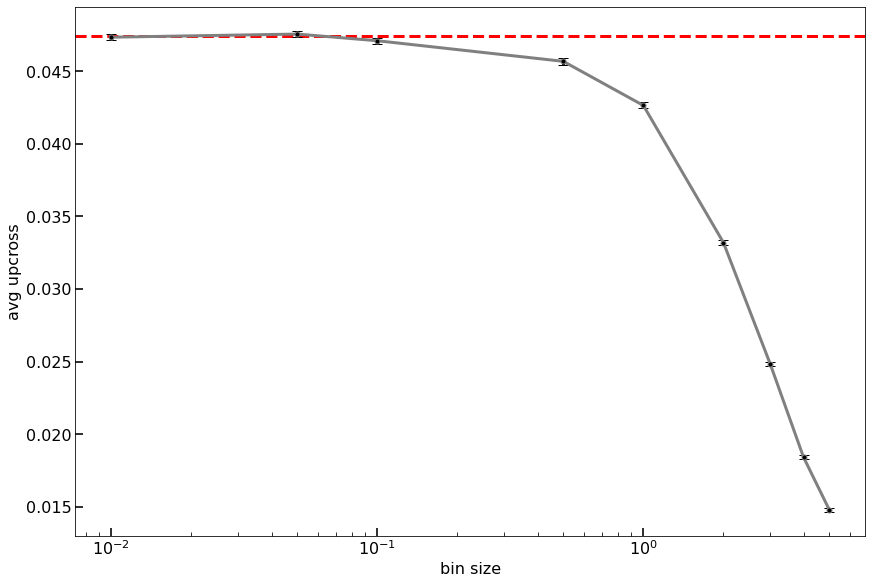

In [133]:
plt.axhline(kernel_upcross([100, 160], LOCAL_SIG_GRID[2]), ls="--", color="red")
plt.errorbar(binsizes, upcross_scans[:, 0], yerr=upcross_scans[:, 1], marker="o", color="gray", markerfacecolor="black", ecolor="black", capsize=5)
plt.xscale("log")
plt.xlabel("bin size")
plt.ylabel("avg upcross")

# Peak width depends on its height

In [134]:
xs = np.arange(100, 160, 0.1)
cov = get_covariance_from_kernel(kernel, xs)
sqrt_cov = get_svd_sqrtcov(cov)

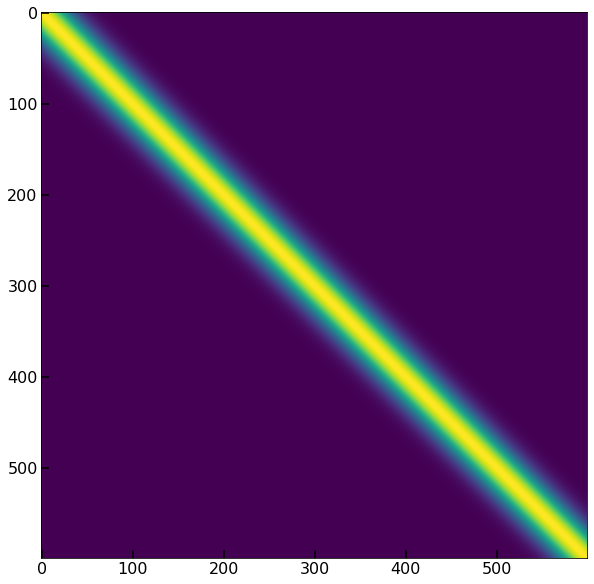

In [135]:
plt.imshow(cov)

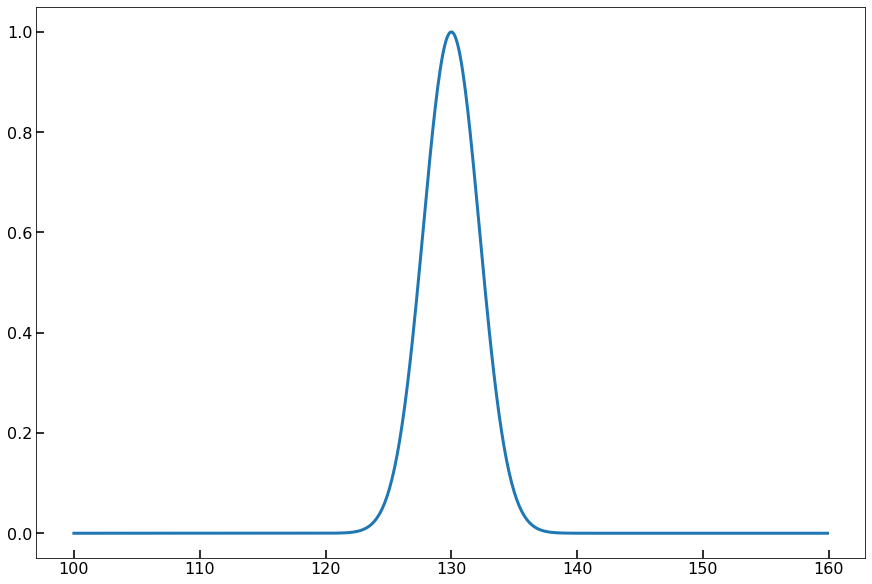

In [136]:
plt.plot(xs, cov[300])

In [220]:
def fit_peak(xs, ys):    
    peak_loc = np.argmax(ys)
    mask = slice(np.max([peak_loc - 20, 0]), np.min([peak_loc + 20, xs.shape[0]]))
    def weight(p):
        return ((p[3]**2*np.exp(-(xs[mask]-p[0])**2/2/p[1]**2) + p[2] - ys[mask])**2).sum()
    return sp.optimize.minimize(weight, x0=[xs[peak_loc], 1, ys[mask].min(), np.sqrt(ys[mask].max()-ys[mask].min())])

In [221]:
fit_peak(xs, cov[300])

      fun: 2.103628115218005e-11
 hess_inv: array([[ 3.95486232e-01, -9.00791044e-01,  7.09048942e-01,
        -3.51609624e-01],
       [-9.00791044e-01,  6.25196009e+02, -4.71640312e+02,
         2.34312341e+02],
       [ 7.09048942e-01, -4.71640312e+02,  3.56559187e+02,
        -1.77187748e+02],
       [-3.51609624e-01,  2.34312341e+02, -1.77187748e+02,
         8.80585447e+01]])
      jac: array([ 2.25161600e-07, -1.22861653e-06,  2.16419133e-06,  7.65147725e-06])
  message: 'Optimization terminated successfully.'
     nfev: 215
      nit: 37
     njev: 43
   status: 0
  success: True
        x: array([1.30000000e+02, 2.23591394e+00, 1.14844571e-04, 9.99943094e-01])

## Toy samples for RnD

In [171]:
samples = draw_gp_from_sqrtcov(sqrt_cov, 100_000)

In [172]:
peaks = np.argmax(samples, axis=1)

In [173]:
non_zero_mask = (peaks > 80) & (peaks < (xs.shape[0] - 80))

In [174]:
samples_nonzero = samples[non_zero_mask]

In [175]:
peaks_nonzero = peaks[non_zero_mask]

In [218]:
def one_peak(xs, sample):
    res = fit_peak(xs, sample)
    plt.plot(xs, sample)
    peak_loc = np.argmax(sample)
    plt.axvline(xs[peak_loc])
    plt.axvline(xs[peak_loc-10])
    plt.axvline(xs[peak_loc+10])
    print(res)
    plt.plot(xs, res.x[3]**2*np.exp(-(res.x[0]-xs)**2/2/res.x[1]**2) + res.x[2])

In [222]:
def _one_peak_interact(i):
    one_peak(xs, samples_nonzero[i])

ipw.interact(_one_peak_interact, i=(0, samples_nonzero.shape[0]-1))

interactive(children=(IntSlider(value=35162, description='i', max=70325), Output()), _dom_classes=('widget-int…

<function __main__._one_peak_interact(i)>

## Fit many peaks

In [224]:
class PeakWidthCalculator(Calculator):
    def __init__(self, xs):
        self.xs = xs
        
    def process_batch(self, samples):
        widths = np.empty_like(samples, shape=samples.shape[0])
        peak_heights = np.max(samples, axis=1)
        for i, sample in enumerate(samples):
            widths[i] = fit_peak(self.xs, sample).x[1]
        return np.vstack([peak_heights, widths]).T

In [305]:
CFG.FITTER.bfit_pool_size = 100
bs = list(gp_batch_mapreduce(cov, 1_000_000, 50, xs.shape[:1], PeakWidthCalculator(xs), Reducer()))
CFG.FITTER.bfit_pool_size = 30

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [34:14<00:00, 486.64it/s]


In [306]:
res = np.vstack(bs)
res.shape

(1000000, 2)

In [366]:
def get_plot(peak_heights, widths):
    h1, bins = np.histogram(peak_heights, bins=30, weights=widths)
    h2, _ = np.histogram(peak_heights, bins=bins)
    h3, _ = np.histogram(peak_heights, bins=bins, weights=widths**2)
    h2 = h2 + 0.0001
    fig, ax = plt.subplots(nrows=2, figsize=(12, 8), gridspec_kw={'height_ratios': [7, 4]})
    xs = (bins[1:] + bins[:-1])/2
    ys = h1/h2
    yerr = np.sqrt(h3/h2 - (h1/h2)**2)/np.sqrt(h2)
    ax[0].errorbar(xs, ys, yerr=yerr, capsize=5, ls="", marker="o", color="black", ecolor="black", label="peak width")
    res = sp.stats.linregress(xs, ys)
    ax[0].plot(xs, res.slope*xs + res.intercept, ls="--", color="red", label=f"ax+b (a={res.slope:.2}, b={res.intercept:.2})")
    ax[0].set_ylim([0, 15])
    ax[0].set_xlabel("peak height")
    ax[0].set_ylabel("effective peak width")
    ax[0].legend()
    ax[1].bar(xs, h2, bins[1]-bins[0])
    ax[1].set_xlabel("peak height")
    ax[1].set_ylabel("number of events")

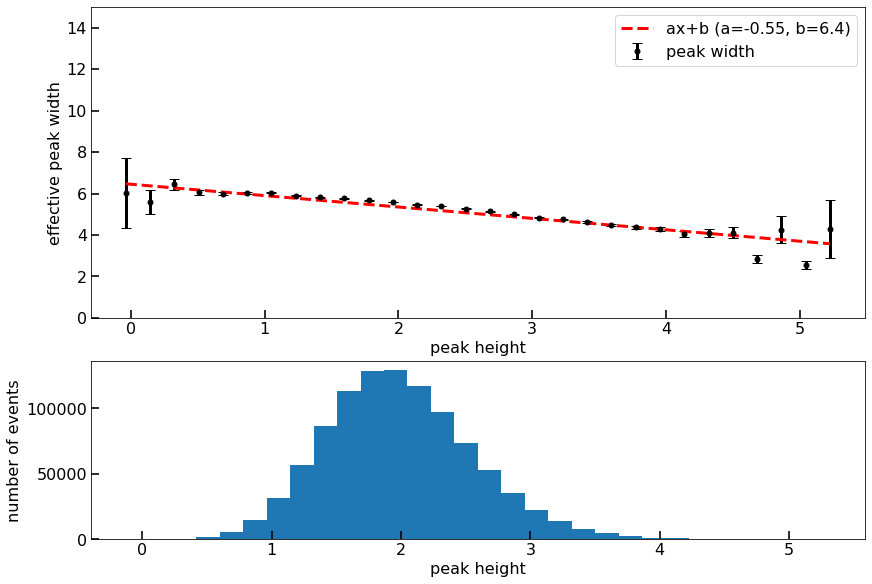

In [367]:
get_plot(res[:, 0], res[:, 1])

In [363]:
res[:, 0].mean()

1.9884846150608322

In [364]:
2*np.pi/np.sqrt(ALPHA)

1.98691765315922